### Introductory Remarks
The World Health Organization (WHO) characterized COVID-19, caused by SARS-CoV-2, as a pandemic on March 11, 2020; and as of May 13, 2020, over 4 million cases have been identified across the globe and over 300,000 people have died due to the virus. With the exponential increase in the number of cases risking to overwhelm health systems around the world due to a demand for ICU beds, ventilators, and protective gear for hospital staff, the ability to rapidly determine whether a patient is infected with the virus is paramount. In addition, the number of tests in multiple parts of the world have been extremely limited. At the same time, testing everyone is currently impractical and would further overwhelm labratories increasingly delaying results.

However as the world transitions from flattening to curve to modified social distancing, increasing testing is vital as countries around the world begin to "open back up".  A model that could give health care providers a better idea of who should be tested to determine positive cases sooner to allow for contact tracing would be invaluable.

This particular dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital. All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

Source: https://www.kaggle.com/dataset/e626783d4672f182e7870b1bbe75fae66bdfb232289da0a61f08c2ceb01cab01

### Prepare the Environment

In [1]:
#add packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#from scikit learn
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB

from mlxtend.plotting import heatmap

Using TensorFlow backend.


In [2]:
#load the data
df = pd.read_excel("../input/covid19/dataset.xlsx")
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

In [3]:
#look at the shape of the dataset
df.shape

(5644, 111)

One of the tasks associated with this dataset on Kaggle was, not only to predict COVID-19 exam results, but also whether a patient will need to be admitted to a general ward, semi-intensive unit or intensive care unit.  Since I will only be performing the first task, I have chosen to eliminate these three columns, as well as the non-predictive 'Patient ID' column.

In [4]:
#eliminate non-predictive features
df = df.drop(['Patient ID', 'Patient addmited to regular ward (1=yes, 0=no)',
              'Patient addmited to semi-intensive unit (1=yes, 0=no)', 
              'Patient addmited to intensive care unit (1=yes, 0=no)'], axis = 1)

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64


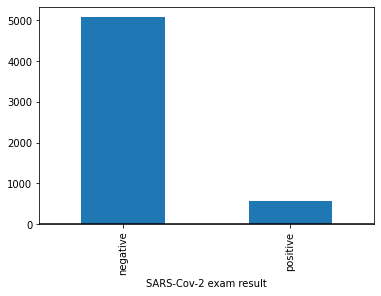

In [5]:
#create a bar graph for the target variable
target = df.groupby('SARS-Cov-2 exam result')
targetEDA=target['SARS-Cov-2 exam result'].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False)
plt.axhline(0, color='k')

print(df['SARS-Cov-2 exam result'].value_counts())

# Data Preprocessing
The first step in preprocessing the data is dealing with the large number of missing values in the dataset.

In [6]:
#check for null values
df.isna().sum() 

Patient age quantile                     0
SARS-Cov-2 exam result                   0
Hematocrit                            5041
Hemoglobin                            5041
Platelets                             5042
                                      ... 
HCO3 (arterial blood gas analysis)    5617
pO2 (arterial blood gas analysis)     5617
Arteiral Fio2                         5624
Phosphor                              5624
ctO2 (arterial blood gas analysis)    5617
Length: 107, dtype: int64

In [7]:
#remove columns with more than 90% null values
pct_null = df.isnull().sum() / len(df)
missing_features = pct_null[pct_null > 0.90].index
df.drop(missing_features, axis = 1, inplace = True)

In [8]:
#convert categorical variables to binary
mask_pos_neg = {'positive': 1, 'negative': 0}
mask_detected = {'detected': 1, 'not_detected': 0}
df = df.replace(mask_detected)
df = df.replace(mask_pos_neg)

Presumably the large number of missing values is due to blood work and/or tests not being performed. To deal with tests not being run to check for other infections, I replaced these null values with a zero.  My assumption is that not performing the test is akin to the test coming back negative. Then, I summed up all of the test columns to created a new feature: "other_infection". This new feature provides information about whether or not a different infection had been detected in the patient.

For the second iteration of this project, instead of condensing the infection tests into a single column, I left them in their original form.  However, this sparser dataset just seemed to increase the noise in the data, so I decided to continue using the "other infection" feature.

In [9]:
#replace null values for columns 16-35 (the test result columns) with zeros
df[df.columns[16:]] = df[df.columns[16:]].fillna(0)

In [10]:
#remove any column with the same value because they provide no predictive value
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df = df.drop(cols_to_drop, axis=1)

In [11]:
#create the new "other infection" feature
df['other infection'] = df[df.columns[16:]].sum(axis = 1)
df.loc[df['other infection'] > 1, 'other infection'] = 1

In [12]:
#remove individual test result columns
df = df.drop(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63',
              'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
              'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009',
              'Bordetella pertussis', 'Metapneumovirus', 'Influenza B, rapid test', 'Influenza A, rapid test'], 
             axis = 1)

For the second iteration of this project, I tried imputing the missing blood work data.  Although this did improve the overall accuracy of many of the models by a few percentage points, I was wary of these outputs due to the more biased inputs.  As I mentioned in the first iteration of this project, I believe clinical data (especially when this much is missing) is far too sensitive and unique to simply impute values.  I also did not believe there was enough information per observation to use regression imputation.  In addition, the observations with missing blood work appeared to be at random, so I did not feel that deleting these observations, and only using complete cases, would result in a loss of information.

In [13]:
#remove any row with missing data
df = df.dropna(thresh = 17)

In [14]:
#check for any remaining null values
df.isna().sum() 

Patient age quantile                                0
SARS-Cov-2 exam result                              0
Hematocrit                                          0
Hemoglobin                                          0
Platelets                                           0
Mean platelet volume                                0
Red blood Cells                                     0
Lymphocytes                                         0
Mean corpuscular hemoglobin concentration (MCHC)    0
Leukocytes                                          0
Basophils                                           0
Mean corpuscular hemoglobin (MCH)                   0
Eosinophils                                         0
Mean corpuscular volume (MCV)                       0
Monocytes                                           0
Red blood cell distribution width (RDW)             0
other infection                                     0
dtype: int64

In [15]:
#move the target variable to the first column in the dataset
#designate target variable name
targetName = 'SARS-Cov-2 exam result'
targetSeries = df[targetName]

#remove target from current location
df.drop(columns = 'SARS-Cov-2 exam result', inplace = True)

#reinsert column back into the dataframe in the 0-th (i.e. first) position
df.insert(0, targetName, targetSeries)

To further simplify the dataset, a correlation matrix was created to determine collinearity between predictors.  If predictors had a correlation coefficient above 0.90, one of them was removed.

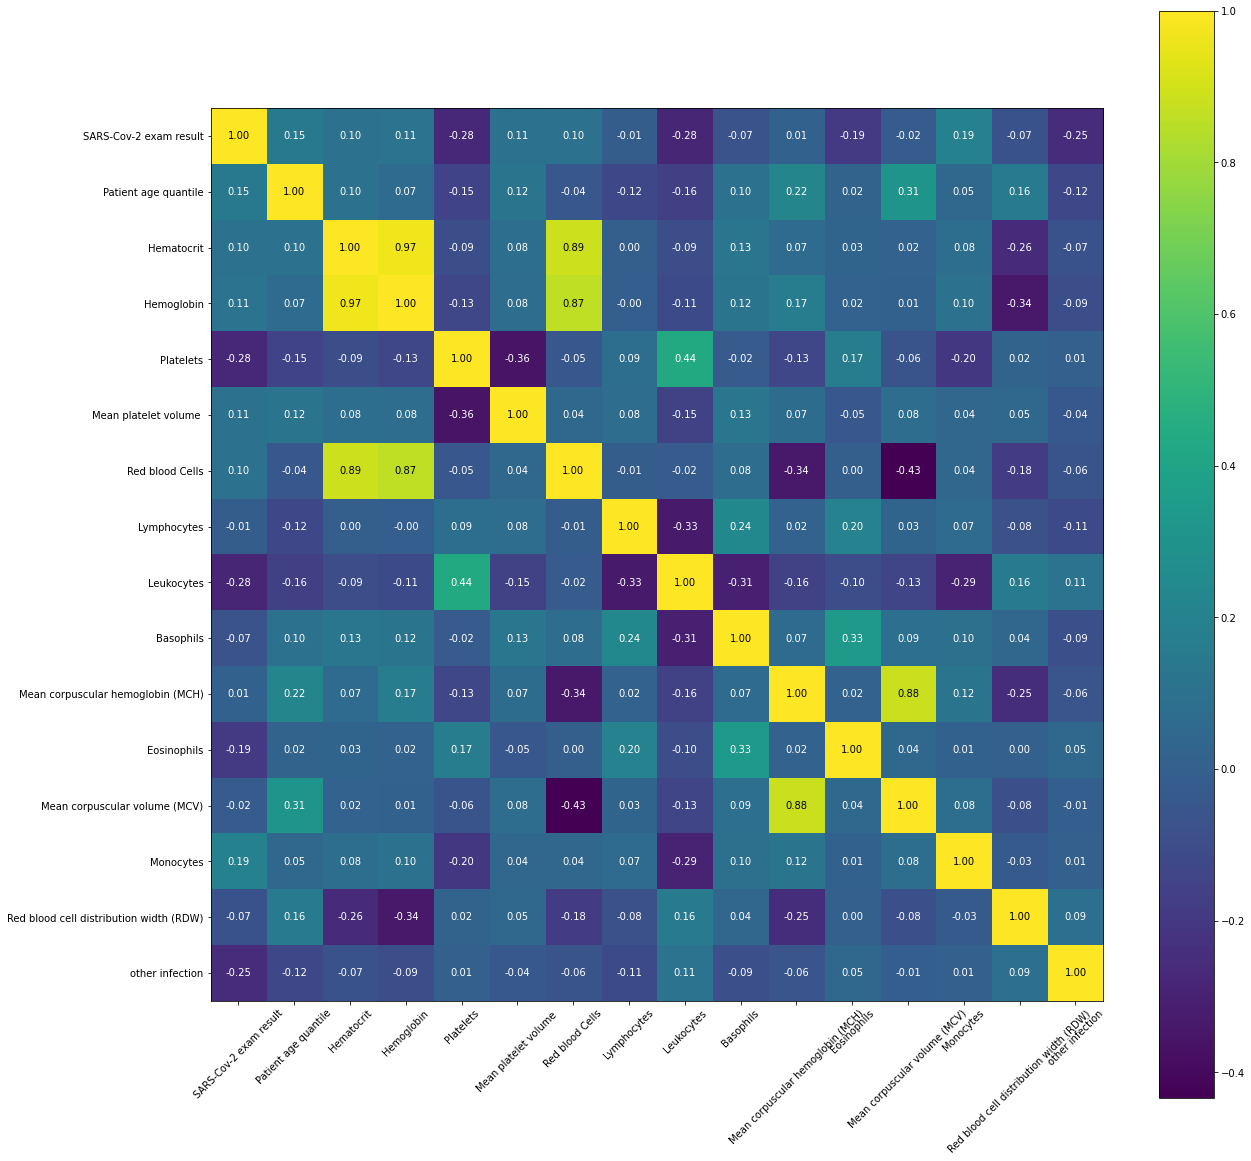

In [16]:
#create a correlation matrix to check for predictor collinearity
cols = ['SARS-Cov-2 exam result', 'Patient age quantile', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Leukocytes',
        'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)',
        'other infection']
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, figsize = (20, 20), row_names = cols, column_names = cols)
plt.show()

"Hematocrit" and "Hemoglobin" have a correlation coefficient of 0.97.

In [17]:
#remove the "Hematocrit" column
df = df.drop(['Hematocrit'], axis = 1)

For the second iteration of this project, I attempted to use random over sampling for the minority class due to the class imbalance.  However, this approach caused models to severely overfit the data. Therefore, I chose to use the same data as the first iteration of the project.

0    517
1     81
Name: SARS-Cov-2 exam result, dtype: int64


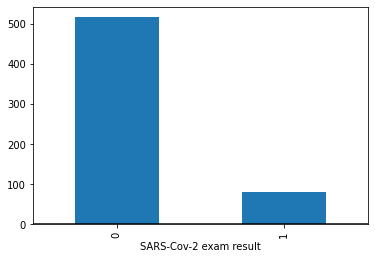

In [18]:
#create a bar graph for the target variable
target = df.groupby('SARS-Cov-2 exam result')
targetEDA = target['SARS-Cov-2 exam result'].aggregate(len)
plt.figure()
targetEDA.plot(kind = 'bar', grid = False)
plt.axhline(0, color = 'k')

print(df['SARS-Cov-2 exam result'].value_counts())

9.887% of the original dataset was positive cases.  The cleaned dataset contained 13.545% positive cases, so even though there is a large imbalance in the target classes, the ratio within the target class remains similar.

In [19]:
#create a 70/30 training and test set split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 8, stratify = y) #stratify to ensure the target class is proportions

# k-Nearest Neighbor Classifiers
### kNN Model 1

In [20]:
#call the default model
knn_clf = KNeighborsClassifier()
#check the default parameter settings
print(knn_clf)

#fit the classifier to the training data
knn_clf = knn_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_knn = knn_clf.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [21]:
#develop a classification report
print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn))
print("kNN Recall Score", recall_score(y_test, target_predicted_knn))
print("kNN ROC AUC Score", roc_auc_score(y_test, target_predicted_knn))
print(classification_report(y_test, target_predicted_knn))

kNN Accuracy Score 0.8777777777777778
kNN Recall Score 0.2916666666666667
kNN ROC AUC Score 0.6298076923076924
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       156
           1       0.58      0.29      0.39        24

    accuracy                           0.88       180
   macro avg       0.74      0.63      0.66       180
weighted avg       0.86      0.88      0.86       180



In [22]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(knn_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.9047619  0.88095238 0.88095238 0.76190476 0.80952381 0.88095238
 0.9047619  0.80952381 0.87804878 0.92682927]


0.8638211382113822

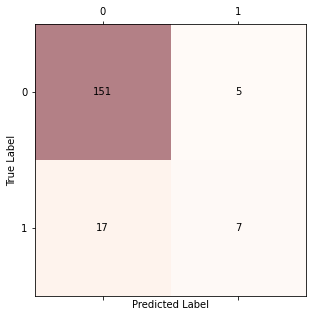

In [23]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_knn)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### kNN Model 2
To try and develop a better model, a grid search was conducted to determine the type of distance measurement and weight calculation to use along with an appropriate k-value using roc_auc scoring.

In [24]:
#create the grid
param_grid2 = {'n_neighbors' : [1, 2, 3, 4, 5], 'p' : [1, 2], 'weights' : ['uniform', 'distance']}

#run the grid search
grid_search = GridSearchCV(knn_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [25]:
#call the new model
knn_clf2 = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'distance')
#check the parameter settings
print(knn_clf2)

#fit the classifier to the training data
knn_clf2 = knn_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_knn2 = knn_clf2.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')


In [26]:
#develop a classification report
print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn2))
print("kNN Recall Score", recall_score(y_test, target_predicted_knn2))
print("kNN ROC AUC Score", roc_auc_score(y_test, target_predicted_knn2))
print(classification_report(y_test, target_predicted_knn2))

kNN Accuracy Score 0.8777777777777778
kNN Recall Score 0.2916666666666667
kNN ROC AUC Score 0.6298076923076924
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       156
           1       0.58      0.29      0.39        24

    accuracy                           0.88       180
   macro avg       0.74      0.63      0.66       180
weighted avg       0.86      0.88      0.86       180



In [27]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(knn_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.9047619  0.88095238 0.88095238 0.76190476 0.80952381 0.88095238
 0.9047619  0.80952381 0.87804878 0.92682927]


0.8638211382113822

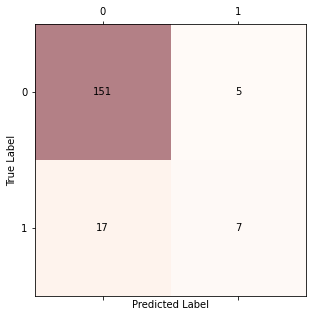

In [28]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_knn2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### kNN Model 3
Since the largest k-value was selected during the last grid search, larger value of k were checked to further improve the model using roc_auc scoring.

In [29]:
#create the grid
param_grid3 = {'n_neighbors' : [5, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'p' : [1, 2], 'weights' : ['uniform', 'distance']}

#run the grid search
grid_search = GridSearchCV(knn_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}


In [30]:
#call the new model
knn_clf3 = KNeighborsClassifier(n_neighbors = 21, p = 1, weights = 'uniform')
#check the parameter settings
print(knn_clf3)

#fit the classifier to the training data
knn_clf3 = knn_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_knn3 = knn_clf3.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=1,
                     weights='uniform')


In [31]:
#develop a classification report
print("kNN Accuracy Score", accuracy_score(y_test, target_predicted_knn3))
print("kNN Recall Score", recall_score(y_test, target_predicted_knn3))
print("kNN ROC AUC Score", roc_auc_score(y_test, target_predicted_knn3))
print(classification_report(y_test, target_predicted_knn3))

kNN Accuracy Score 0.8833333333333333
kNN Recall Score 0.16666666666666666
kNN ROC AUC Score 0.5801282051282052
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.80      0.17      0.28        24

    accuracy                           0.88       180
   macro avg       0.84      0.58      0.61       180
weighted avg       0.87      0.88      0.85       180



In [32]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(knn_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.9047619  0.88095238 0.9047619  0.85714286 0.85714286 0.88095238
 0.85714286 0.85714286 0.90243902 0.90243902]


0.8804878048780488

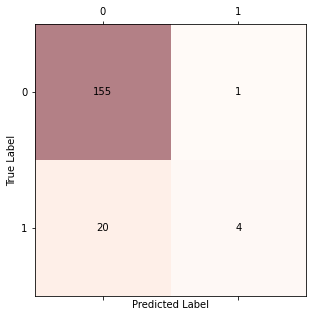

In [33]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_knn3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Decision Tree Classifiers
### DT Model 1

In [34]:
#call the default model
dt_clf = DecisionTreeClassifier(random_state = 8)
#check the default parameter settings
print(dt_clf)

#fit the classifier to the training data
dt_clf = dt_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_dt = dt_clf.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8, splitter='best')


In [35]:
#create a classification report
print("DT Accuracy Score", accuracy_score(y_test, target_predicted_dt))
print("DT Recall Score", recall_score(y_test, target_predicted_dt))
print("DT ROC AUC Score", roc_auc_score(y_test, target_predicted_dt))
print(classification_report(y_test, target_predicted_dt))

DT Accuracy Score 0.8666666666666667
DT Recall Score 0.375
DT ROC AUC Score 0.6586538461538461
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       156
           1       0.50      0.38      0.43        24

    accuracy                           0.87       180
   macro avg       0.70      0.66      0.68       180
weighted avg       0.85      0.87      0.86       180



In [36]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(dt_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.88095238 0.92857143 0.97619048 0.80952381 0.88095238 0.83333333
 0.85714286 0.76190476 0.7804878  0.82926829]


0.8538327526132404

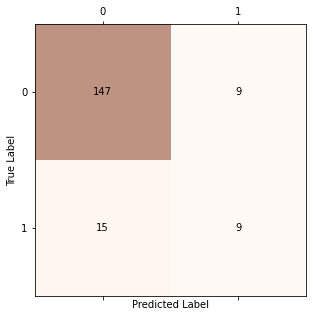

In [37]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_dt)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### DT Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [38]:
#create the grid
param_grid2 = {'criterion' : ['gini', 'entropy'], 'max_depth' : [0, 1, 2, 3, 4, 5], 'splitter' : ['best', 'random']}

#run the grid search
grid_search = GridSearchCV(dt_clf, param_grid = param_grid2, scoring = "roc_auc", n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}


In [39]:
#call the new model
dt_clf2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, splitter = 'random', random_state = 8)
#check the parameter settings
print(dt_clf2)

#fit the classifier to the training data
dt_clf2 = dt_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_dt2 = dt_clf2.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8, splitter='random')


In [40]:
#create a classification report
print("DT Accuracy Score", accuracy_score(y_test, target_predicted_dt2))
print("DT Recall Score", recall_score(y_test, target_predicted_dt2))
print("DT ROC AUC Score", roc_auc_score(y_test, target_predicted_dt2))
print(classification_report(y_test, target_predicted_dt2))

DT Accuracy Score 0.8611111111111112
DT Recall Score 0.0
DT ROC AUC Score 0.4967948717948718
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       156
           1       0.00      0.00      0.00        24

    accuracy                           0.86       180
   macro avg       0.43      0.50      0.46       180
weighted avg       0.75      0.86      0.80       180



In [41]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(dt_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.83333333 0.88095238 0.85714286 0.85714286 0.85714286 0.85714286
 0.85714286 0.85714286 0.87804878 0.85365854]


0.858885017421603

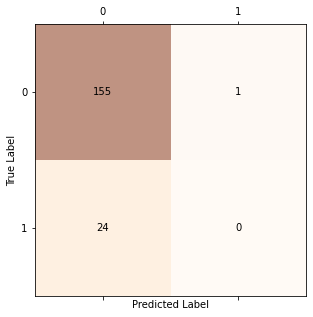

In [42]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_dt2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### DT Model 3
Since the max_depth argument chosen in the last grid search was the largest value, another grid search was performed with larger values. The class weight hyperparameter was also included using roc_auc scoring.

In [43]:
#create the grid
param_grid3 = {'class_weight' : ['None', 'balanced'], 'criterion' : ['gini', 'entropy'], 'max_depth' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'splitter' : ['best', 'random']}

#run the grid search
grid_search = GridSearchCV(dt_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}


In [44]:
#call the new model
dt_clf3 = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 2, splitter = 'best', random_state = 8)
#check the parameter settings
print(dt_clf3)

#fit the classifier to the training data
dt_clf3 = dt_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_dt3 = dt_clf3.predict(X_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8, splitter='best')


In [45]:
#create a classification report
print("DT Accuracy Score", accuracy_score(y_test, target_predicted_dt3))
print("DT Recall Score", recall_score(y_test, target_predicted_dt3))
print("DT ROC AUC Score", roc_auc_score(y_test, target_predicted_dt3))
print(classification_report(y_test, target_predicted_dt3))

DT Accuracy Score 0.8111111111111111
DT Recall Score 0.7083333333333334
DT ROC AUC Score 0.7676282051282051
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       156
           1       0.39      0.71      0.50        24

    accuracy                           0.81       180
   macro avg       0.67      0.77      0.69       180
weighted avg       0.87      0.81      0.83       180



In [46]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(dt_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.76190476 0.85714286 0.92857143 0.83333333 0.85714286 0.71428571
 0.78571429 0.69047619 0.80487805 0.87804878]


0.8111498257839722

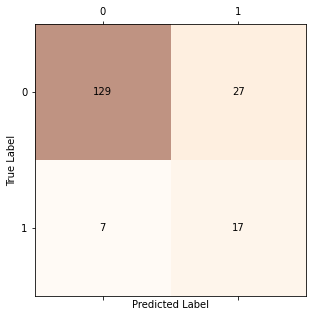

In [47]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_dt3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Random Forest Classifiers
### RF Model 1

In [48]:
#call the default model
rf_clf = RandomForestClassifier(random_state = 8)
#check the default parameter settings
print(rf_clf)

#fit the classifier to the training data
rf_clf = rf_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_rf = rf_clf.predict(X_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


In [49]:
#create a classification report
print("RF Accuracy Score", accuracy_score(y_test, target_predicted_rf))
print("RF Recall Score", recall_score(y_test, target_predicted_rf))
print("RF ROC AUC Score", roc_auc_score(y_test, target_predicted_rf))
print(classification_report(y_test, target_predicted_rf))

RF Accuracy Score 0.9
RF Recall Score 0.2916666666666667
RF ROC AUC Score 0.6426282051282052
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       156
           1       0.88      0.29      0.44        24

    accuracy                           0.90       180
   macro avg       0.89      0.64      0.69       180
weighted avg       0.90      0.90      0.88       180



In [50]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(rf_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.88095238 0.9047619  0.88095238 0.9047619  0.9047619
 0.92857143 0.85714286 0.90243902 0.92682927]


0.8948315911730547

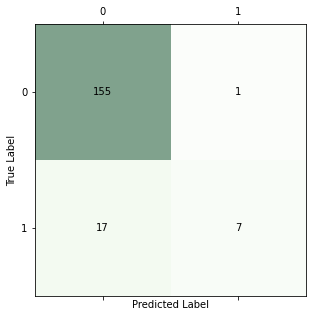

In [51]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_rf)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### RF Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [52]:
#create the grid
param_grid2 = {'class_weight' : ['None', 'balanced', 'balanced_subsample'], 'criterion' : ['gini', 'entropy'], 'max_depth' : [1, 2, 3, 4, 5]}

#run the grid search
grid_search = GridSearchCV(rf_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5}


In [53]:
#call the new model
rf_clf2 = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 5, random_state = 8)
#check the parameter settings
print(rf_clf2)

#fit the classifier to the training data
rf_clf2 = rf_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_rf2 = rf_clf2.predict(X_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


In [54]:
#create a classification report
print("RF Accuracy Score", accuracy_score(y_test, target_predicted_rf2))
print("RF Recall Score", recall_score(y_test, target_predicted_rf2))
print("RF ROC AUC Score", roc_auc_score(y_test, target_predicted_rf2))
print(classification_report(y_test, target_predicted_rf2))

RF Accuracy Score 0.9111111111111111
RF Recall Score 0.5833333333333334
RF ROC AUC Score 0.7724358974358975
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.70      0.58      0.64        24

    accuracy                           0.91       180
   macro avg       0.82      0.77      0.79       180
weighted avg       0.91      0.91      0.91       180



In [55]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(rf_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.92857143 0.95238095 0.9047619  0.88095238 0.88095238
 0.97619048 0.9047619  0.85365854 0.95121951]


0.9114401858304297

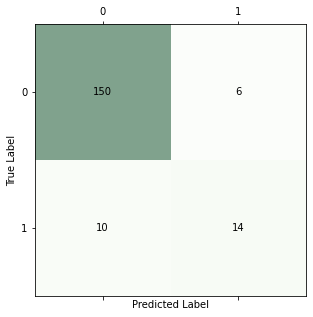

In [56]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_rf2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### RF Model 3
Since the max_depth argument chosen in the last grid search was the largest value, another grid search was performed with larger values.  In addition, this grid search includes the "n_estimator" hyperparameter using roc_auc scoring.

In [57]:
#create the grid
param_grid3 = {'max_depth' : [3, 4, 5, 6, 7], 'n_estimators' : [100, 200, 300, 400, 500]}

#run the grid search
grid_search = GridSearchCV(rf_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'max_depth': 7, 'n_estimators': 300}


In [58]:
#call the new model
rf_clf3 = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 7, n_estimators = 300, random_state = 8)
#check the parameter settings
print(rf_clf3)

#fit the classifier to the training data
rf_clf3 = rf_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_rf3 = rf_clf3.predict(X_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


In [59]:
#create a classification report
print("RF Accuracy Score", accuracy_score(y_test, target_predicted_rf3))
print("RF Recall Score", recall_score(y_test, target_predicted_rf3))
print("RF ROC AUC Score", roc_auc_score(y_test, target_predicted_rf3))
print(classification_report(y_test, target_predicted_rf3))

RF Accuracy Score 0.9
RF Recall Score 0.5416666666666666
RF ROC AUC Score 0.7483974358974359
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       156
           1       0.65      0.54      0.59        24

    accuracy                           0.90       180
   macro avg       0.79      0.75      0.77       180
weighted avg       0.89      0.90      0.90       180



In [60]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(rf_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.92857143 0.88095238 0.92857143 0.9047619  0.9047619
 0.95238095 0.85714286 0.87804878 0.97560976]


0.906794425087108

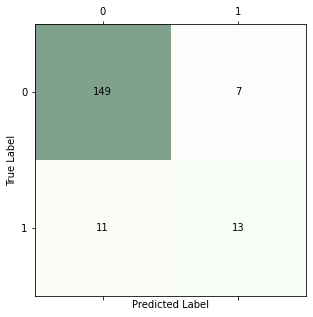

In [61]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_rf3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Extra Trees Classifiers
### ET Model 1

In [62]:
#call the default model
et_clf = ExtraTreesClassifier(random_state = 8)
#check the default parameter settings
print(et_clf)

#fit the classifier to the training data
et_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_et = et_clf.predict(X_test)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=8, verbose=0,
                     warm_start=False)


In [63]:
#create a classification report
print("ET Accuracy Score", accuracy_score(y_test, target_predicted_et))
print("ET Recall Score", recall_score(y_test, target_predicted_et))
print("ET ROC AUC Score", roc_auc_score(y_test, target_predicted_et))
print(classification_report(y_test, target_predicted_et))

ET Accuracy Score 0.8888888888888888
ET Recall Score 0.2916666666666667
ET ROC AUC Score 0.6362179487179488
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       156
           1       0.70      0.29      0.41        24

    accuracy                           0.89       180
   macro avg       0.80      0.64      0.68       180
weighted avg       0.87      0.89      0.87       180



In [64]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(et_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.92857143 0.92857143 0.92857143 0.9047619  0.9047619  0.9047619
 0.92857143 0.80952381 0.92682927 0.92682927]


0.9091753774680604

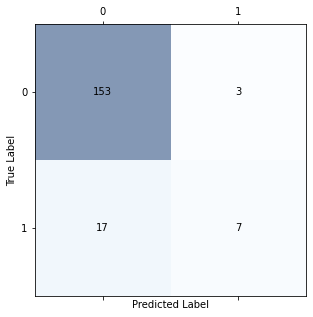

In [65]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_et)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ET Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [66]:
#create the grid
param_grid2 = {'bootstrap' : ['True', 'False'], 'class_weight' : ['None', 'balanced', 'balanced_subsample'], 'criterion' : ['gini', 'entropy'], 'max_depth' : [1, 2, 3, 4, 5],
               'n_estimators' : [100, 200, 300, 400, 500]}

#run the grid search
grid_search = GridSearchCV(et_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'bootstrap': 'True', 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}


In [67]:
#call the new model
et_clf2 = ExtraTreesClassifier(bootstrap = True, class_weight = 'balanced', criterion = 'gini', max_depth = 5, n_estimators = 100, random_state = 8)
#check the parameter settings
print(et_clf2)

#fit the classifier to the training data
et_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_et2 = et_clf2.predict(X_test)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=8, verbose=0,
                     warm_start=False)


In [68]:
#create a classification report
print("ET Accuracy Score", accuracy_score(y_test, target_predicted_et2))
print("ET Recall Score", recall_score(y_test, target_predicted_et2))
print("ET ROC AUC Score", roc_auc_score(y_test, target_predicted_et2))
print(classification_report(y_test, target_predicted_et2))

ET Accuracy Score 0.8333333333333334
ET Recall Score 0.7916666666666666
ET ROC AUC Score 0.8157051282051282
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       156
           1       0.43      0.79      0.56        24

    accuracy                           0.83       180
   macro avg       0.70      0.82      0.73       180
weighted avg       0.89      0.83      0.85       180



In [69]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(et_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.83333333 0.85714286 0.92857143 0.92857143 0.78571429 0.85714286
 0.88095238 0.78571429 0.80487805 0.90243902]


0.8564459930313589

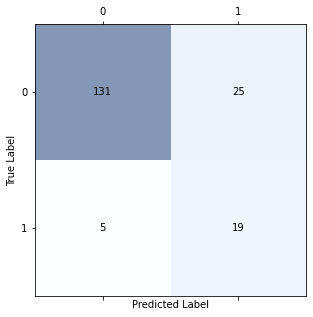

In [70]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_et2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ET Model 3
Since the max_depth argument chosen in the last grid search was the largest value, another grid search was performed with larger values. In addition, the n_estimator argument chosen in the last grid search was the smallest value, smaller values were used in this grid search using roc_auc scoring.

In [71]:
#create the grid
param_grid3 = {'max_depth' : [3, 4, 5, 6, 7, 8], 'n_estimators' : [50, 60, 70, 80, 90, 100]}

#run the grid search
grid_search = GridSearchCV(et_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'max_depth': 5, 'n_estimators': 70}


In [72]:
#call the new model
et_clf3 = ExtraTreesClassifier(bootstrap = True, class_weight = 'balanced_subsample', max_depth = 5, n_estimators = 70, random_state = 8)
#check the parameter settings
print(et_clf3)

#fit the classifier to the training data
et_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_et3 = et_clf3.predict(X_test)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=5, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=70, n_jobs=None, oob_score=False,
                     random_state=8, verbose=0, warm_start=False)


In [73]:
#create a classification report
print("ET Accuracy Score", accuracy_score(y_test, target_predicted_et3))
print("ET Recall Score", recall_score(y_test, target_predicted_et3))
print("ET ROC AUC Score", roc_auc_score(y_test, target_predicted_et3))
print(classification_report(y_test, target_predicted_et3))

ET Accuracy Score 0.8222222222222222
ET Recall Score 0.7916666666666666
ET ROC AUC Score 0.8092948717948717
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       156
           1       0.41      0.79      0.54        24

    accuracy                           0.82       180
   macro avg       0.69      0.81      0.72       180
weighted avg       0.89      0.82      0.84       180



In [74]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(et_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.9047619  0.80952381 0.95238095 0.92857143 0.80952381 0.83333333
 0.88095238 0.80952381 0.82926829 0.92682927]


0.8684668989547039

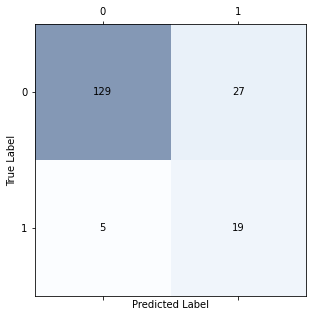

In [75]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_et3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# C-Support Vector Classifiers
In addition to the linear and radial basis function kernals used in the first iteration of this project, a support vector machine model was created using a polynomial kernal for the second iteration of this project.
### SVC (Linear) Model 1

In [76]:
#call the default linear model
svc_lin = SVC(kernel = 'linear', random_state = 8)
#check the default parameter settings
print(svc_lin)

#fit the classifier to the training data
svc_lin.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC = svc_lin.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [77]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC))
print(classification_report(y_test, target_predicted_SVC))

SVC Accuracy Score 0.9166666666666666
SVC Recall Score 0.5416666666666666
SVC ROC AUC Score 0.7580128205128204
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       156
           1       0.76      0.54      0.63        24

    accuracy                           0.92       180
   macro avg       0.85      0.76      0.79       180
weighted avg       0.91      0.92      0.91       180



In [78]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_lin, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.9047619  0.92857143 0.9047619  0.80952381 0.92857143
 0.9047619  0.85714286 0.87804878 0.95121951]


0.8924506387921021

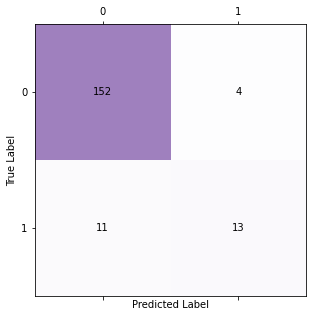

In [79]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (Linear) Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [80]:
#create the grid
param_grid2 = {'C' : [0.5, 1, 2, 3, 4, 5], 'class_weight' : ['None', 'balanced']}

#run the grid search
grid_search = GridSearchCV(svc_lin, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_) 

Best {'C': 0.5, 'class_weight': 'balanced'}


In [81]:
#call the new model
svc_lin2 = SVC(kernel = 'linear', C = 0.5, class_weight = 'balanced', random_state = 8)
#check the parameter settings
print(svc_lin2)

#fit the classifier to the training data
svc_lin2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC2 = svc_lin2.predict(X_test)

SVC(C=0.5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [82]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC2))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC2))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC2))
print(classification_report(y_test, target_predicted_SVC2))

SVC Accuracy Score 0.8055555555555556
SVC Recall Score 0.9583333333333334
SVC ROC AUC Score 0.8701923076923077
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       156
           1       0.40      0.96      0.57        24

    accuracy                           0.81       180
   macro avg       0.70      0.87      0.72       180
weighted avg       0.91      0.81      0.83       180



In [83]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_lin2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.80952381 0.92857143 0.85714286 0.78571429 0.80952381
 0.88095238 0.73809524 0.80487805 0.90243902]


0.8278745644599302

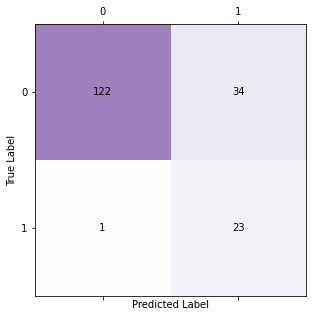

In [84]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (Linear) Model 3
To further refine the model, smaller values and increments of C were checked using roc_auc scoring.

In [85]:
#create the grid
param_grid3 = {'C' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'class_weight' : ['None', 'balanced']}

#run the grid search
grid_search = GridSearchCV(svc_lin2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 0.7, 'class_weight': 'balanced'}


In [86]:
#call the new model
svc_lin3 = SVC(kernel = 'linear', C = 0.7, class_weight = 'balanced', probability = True, random_state = 8)
#check the parameter settings
print(svc_lin3)

#fit the classifier to the training data
svc_lin3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC3 = svc_lin3.predict(X_test)

SVC(C=0.7, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [87]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC3))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC3))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC3))
print(classification_report(y_test, target_predicted_SVC3))

SVC Accuracy Score 0.8055555555555556
SVC Recall Score 0.9583333333333334
SVC ROC AUC Score 0.8701923076923077
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       156
           1       0.40      0.96      0.57        24

    accuracy                           0.81       180
   macro avg       0.70      0.87      0.72       180
weighted avg       0.91      0.81      0.83       180



In [88]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_lin3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.80952381 0.92857143 0.85714286 0.73809524 0.83333333
 0.88095238 0.76190476 0.80487805 0.90243902]


0.8278745644599302

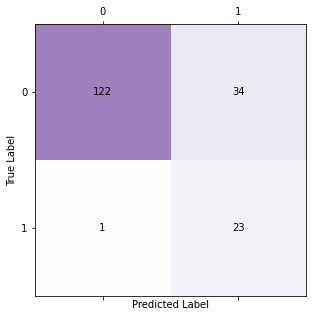

In [89]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### ROC Curve Visualization

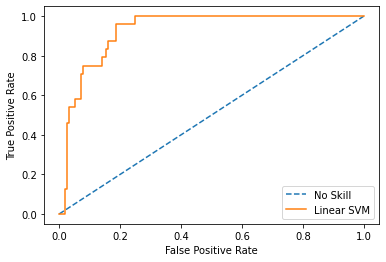

In [90]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = svc_lin3.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'No Skill')
plt.plot(lr_fpr, lr_tpr, marker = '', label = 'Linear SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

##### Feature Importance

In [91]:
#create a dataframe of weight coefficients
features = df.iloc[:,1:]
feature_importance = pd.DataFrame(svc_lin3.coef_, columns = features.columns)
feature_importance = feature_importance.T
feature_importance.nlargest(n = 4, columns = 0)

,0
Monocytes,0.267301
Mean corpuscular volume (MCV),0.210652
Patient age quantile,0.026846
Red blood Cells,0.022773


In [92]:
feature_importance.nsmallest(n = 4, columns = 0)

,0
other infection,-2.288962
Leukocytes,-0.882219
Platelets,-0.597730
Eosinophils,-0.581740


### SVC (RBF) Model 1

In [93]:
#call the default rbf model
svc_rbf = SVC(kernel = 'rbf', random_state = 8)
#check the default parameter settings
print(svc_rbf)

#fit the classifier to the training data
svc_rbf.fit(X_train, y_train)

#make predictions using test data
target_predicted_SVC4 = svc_rbf.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [94]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC4))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC4))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC4))
print(classification_report(y_test, target_predicted_SVC4))

SVC Accuracy Score 0.8666666666666667
SVC Recall Score 0.0
SVC ROC AUC Score 0.5
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       156
           1       0.00      0.00      0.00        24

    accuracy                           0.87       180
   macro avg       0.43      0.50      0.46       180
weighted avg       0.75      0.87      0.80       180



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_rbf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
 0.85714286 0.85714286 0.87804878 0.87804878]


0.8637049941927991

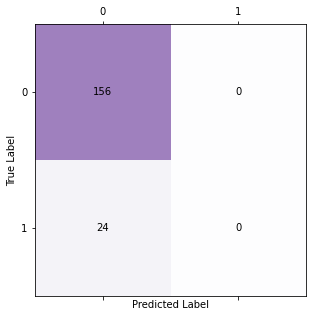

In [96]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC4)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (RBF) Model 2
To try and develop a better model, a grid search was execute to optimize a few of the hyperparameters using roc_auc scoring.

In [97]:
#create the grid
param_grid5 = {'C' : [0.5, 1, 2, 3, 4, 5], 'class_weight' : ['None', 'balanced'], 'gamma' : ['scale', 'auto', 'float']}

#run the grid search
grid_search = GridSearchCV(svc_rbf, param_grid = param_grid5, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 5, 'class_weight': 'balanced', 'gamma': 'auto'}


In [98]:
#call the new model
svc_rbf2 = SVC(kernel = 'rbf', C = 5, class_weight = 'balanced', gamma = 'auto', random_state = 8)
#check the parameter settings
print(svc_rbf2)

#fit the classifier to the training data
svc_rbf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC5 = svc_rbf2.predict(X_test)

SVC(C=5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [99]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC5))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC5))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC5))
print(classification_report(y_test, target_predicted_SVC5))

SVC Accuracy Score 0.8666666666666667
SVC Recall Score 0.3333333333333333
SVC ROC AUC Score 0.641025641025641
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       156
           1       0.50      0.33      0.40        24

    accuracy                           0.87       180
   macro avg       0.70      0.64      0.66       180
weighted avg       0.85      0.87      0.85       180



In [100]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_rbf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.9047619  0.88095238 0.88095238 0.80952381 0.9047619
 0.92857143 0.88095238 0.90243902 0.95121951]


0.8925087108013937

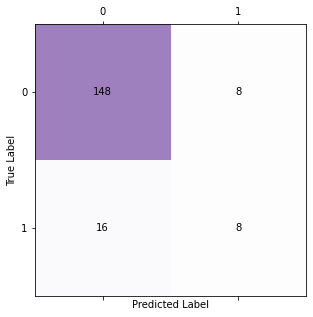

In [101]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC5)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (RBF) Model 3
Since the "C" argument chosen in the last grid search was the largest value, another grid search was performed with larger values and smaller increments using roc_auc scoring.

In [102]:
#create the grid
param_grid6 = {'C' : [5, 7, 9, 9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3], 'class_weight' : ['None', 'balanced'], 'gamma' : ['scale', 'auto', 'float']}

#run the grid search
grid_search = GridSearchCV(svc_rbf2, param_grid = param_grid6, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 10.1, 'class_weight': 'balanced', 'gamma': 'auto'}


In [103]:
#call the new model
svc_rbf3 = SVC(kernel = 'rbf', C = 10.1, class_weight = 'balanced', gamma = 'auto', random_state = 8)
#check the parameter settings
print(svc_rbf3)

#fit the classifier to the training data
svc_rbf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC6 = svc_rbf3.predict(X_test)

SVC(C=10.1, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=-1, probability=False, random_state=8,
    shrinking=True, tol=0.001, verbose=False)


In [104]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC6))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC6))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC6))
print(classification_report(y_test, target_predicted_SVC6))

SVC Accuracy Score 0.8611111111111112
SVC Recall Score 0.3333333333333333
SVC ROC AUC Score 0.6378205128205128
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       156
           1       0.47      0.33      0.39        24

    accuracy                           0.86       180
   macro avg       0.69      0.64      0.66       180
weighted avg       0.84      0.86      0.85       180



In [105]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_rbf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.9047619  0.92857143 0.92857143 0.9047619  0.80952381 0.92857143
 0.92857143 0.88095238 0.92682927 0.95121951]


0.909233449477352

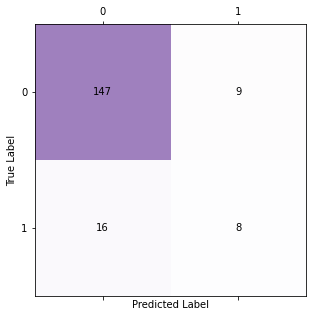

In [106]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC6)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (Poly) Model 1

In [107]:
#call the new model
svc_poly = SVC(kernel = 'poly', random_state = 8)
#check the parameter settings
print(svc_poly)

#fit the classifier to the training data
svc_poly.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC7 = svc_poly.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [108]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC7))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC7))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC7))
print(classification_report(y_test, target_predicted_SVC7))

SVC Accuracy Score 0.8833333333333333
SVC Recall Score 0.16666666666666666
SVC ROC AUC Score 0.5801282051282052
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.80      0.17      0.28        24

    accuracy                           0.88       180
   macro avg       0.84      0.58      0.61       180
weighted avg       0.87      0.88      0.85       180



In [109]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_poly, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.85714286 0.85714286 0.85714286 0.9047619  0.88095238
 0.85714286 0.80952381 0.90243902 0.87804878]


0.8685249709639955

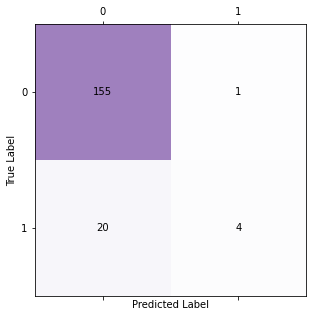

In [110]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC7)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (Poly) Model 2
To try and develop a better model, a grid search was execute to optimize a few of the hyperparameters using roc_auc scoring.

In [111]:
#create the grid
param_grid8 = {'C' : [0.5, 1, 2, 3, 4, 5], 'class_weight' : ['None', 'balanced'], 'gamma' : ['scale', 'auto', 'float']}

#run the grid search
grid_search = GridSearchCV(svc_poly, param_grid = param_grid8, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto'}


In [112]:
#call the new model
svc_poly2 = SVC(kernel = 'poly', C = 0.5, class_weight = 'balanced', gamma = 'auto', random_state = 8)
#check the parameter settings
print(svc_poly2)

#fit the classifier to the training data
svc_poly2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC8 = svc_poly2.predict(X_test)

SVC(C=0.5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [113]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC8))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC8))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC8))
print(classification_report(y_test, target_predicted_SVC8))

SVC Accuracy Score 0.8722222222222222
SVC Recall Score 0.5
SVC ROC AUC Score 0.7147435897435898
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       156
           1       0.52      0.50      0.51        24

    accuracy                           0.87       180
   macro avg       0.72      0.71      0.72       180
weighted avg       0.87      0.87      0.87       180



In [114]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_poly2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.92857143 0.88095238 0.92857143 0.92857143 0.88095238 0.88095238
 0.88095238 0.88095238 0.82926829 0.87804878]


0.8897793263646923

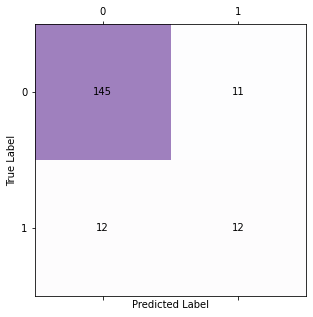

In [115]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC8)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVC (Poly) Model 3
In the previous grid search, the smallest value of C was chosen.  To further improve the model, smaller values and increments of C were checked using roc_auc scoring.

In [116]:
#create the grid
param_grid9 = {'C' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'class_weight' : ['None', 'balanced']}

#run the grid search
grid_search = GridSearchCV(svc_poly2, param_grid = param_grid9, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 0.7, 'class_weight': 'balanced'}


In [117]:
#call the new model
svc_poly3 = SVC(kernel = 'poly', C = 0.7, class_weight = 'balanced', gamma = 'auto', random_state = 8)
#check the parameter settings
print(svc_poly3)

#fit the classifier to the training data
svc_poly3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_SVC9 = svc_poly3.predict(X_test)

SVC(C=0.7, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=8, shrinking=True, tol=0.001,
    verbose=False)


In [118]:
#create a classification report
print("SVC Accuracy Score", accuracy_score(y_test, target_predicted_SVC9))
print("SVC Recall Score", recall_score(y_test, target_predicted_SVC9))
print("SVC ROC AUC Score", roc_auc_score(y_test, target_predicted_SVC9))
print(classification_report(y_test, target_predicted_SVC9))

SVC Accuracy Score 0.8666666666666667
SVC Recall Score 0.5
SVC ROC AUC Score 0.7115384615384616
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       156
           1       0.50      0.50      0.50        24

    accuracy                           0.87       180
   macro avg       0.71      0.71      0.71       180
weighted avg       0.87      0.87      0.87       180



In [119]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(svc_poly3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.92857143 0.88095238 0.92857143 0.95238095 0.88095238 0.85714286
 0.85714286 0.85714286 0.80487805 0.87804878]


0.8825783972125436

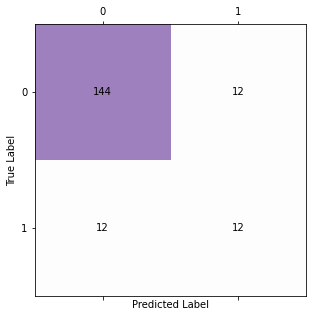

In [120]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_SVC9)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Artificial Neural Network Classifiers
### ANN Model 1

In [121]:
#call the default model
ann_clf = MLPClassifier(max_iter = 1000, random_state = 8)
#check the default parameter settings
print(ann_clf)

#fit the classifier to the training data
ann_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_ann = ann_clf.predict(X_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=8, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [122]:
#create a classification report
print("ANN Accuracy Score", accuracy_score(y_test, target_predicted_ann))
print("ANN Recall Score", recall_score(y_test, target_predicted_ann))
print("ANN ROC AUC Score", roc_auc_score(y_test, target_predicted_ann))
print(classification_report(y_test, target_predicted_ann))

ANN Accuracy Score 0.9111111111111111
ANN Recall Score 0.5416666666666666
ANN ROC AUC Score 0.7548076923076923
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       156
           1       0.72      0.54      0.62        24

    accuracy                           0.91       180
   macro avg       0.83      0.75      0.78       180
weighted avg       0.90      0.91      0.91       180



In [123]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(ann_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.9047619  0.85714286 0.95238095 0.95238095 0.92857143 0.95238095
 0.92857143 0.9047619  0.82926829 0.95121951]


0.9161440185830431

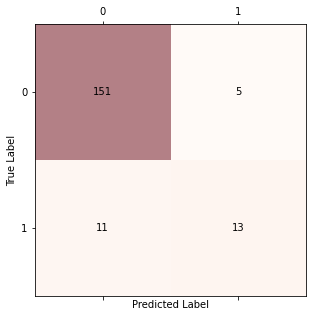

In [124]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_ann)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ANN Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [125]:
#create the grid
param_grid2 = {'activation' : ['tanh', 'relu'], 'alpha' : [0.001, 0.01, 0.1], 'learning_rate_init' : [0.0001, 0.001, 0.01, 0.1], 'solver' : ['lbfgs', 'sgd', 'adam']}

#run the grid search
grid_search = GridSearchCV(ann_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'activation': 'tanh', 'alpha': 0.1, 'learning_rate_init': 0.01, 'solver': 'adam'}


In [126]:
#call the new model
ann_clf2 = MLPClassifier(activation = 'tanh', alpha = 0.1, learning_rate_init = 0.01, max_iter = 1000, solver = 'adam', random_state = 8)
#check the parameter settings
print(ann_clf2)

#fit the classifier to the training data
ann_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_ann2 = ann_clf2.predict(X_test)

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=8, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [127]:
#create a classification report
print("ANN Accuracy Score", accuracy_score(y_test, target_predicted_ann2))
print("ANN Recall Score", recall_score(y_test, target_predicted_ann2))
print("ANN ROC AUC Score", roc_auc_score(y_test, target_predicted_ann2))
print(classification_report(y_test, target_predicted_ann2))

ANN Accuracy Score 0.8777777777777778
ANN Recall Score 0.625
ANN ROC AUC Score 0.7708333333333333
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       156
           1       0.54      0.62      0.58        24

    accuracy                           0.88       180
   macro avg       0.74      0.77      0.75       180
weighted avg       0.89      0.88      0.88       180



In [128]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(ann_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.92857143 0.85714286 0.95238095 0.92857143 0.85714286 0.95238095
 0.95238095 0.85714286 0.87804878 0.85365854]


0.9017421602787457

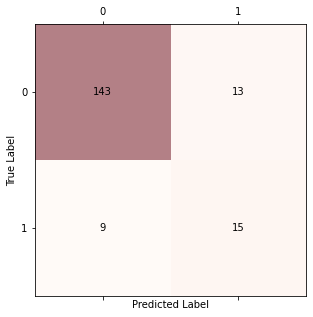

In [129]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_ann2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ANN Model 3
To further improve the model, a different combination of hidden layers and nodes was checked, as well as additional values of alpha using roc_auc scoring.

In [130]:
#create the grid
param_grid3 = {'alpha' : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 'hidden_layer_sizes' : [(100, ), (200, ), (100, 50), (50, 50, 50), (200, 100, 50)]}

#run the grid search
grid_search = GridSearchCV(ann_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'alpha': 0.4, 'hidden_layer_sizes': (100, 50)}


In [131]:
#call the new model
ann_clf3 = MLPClassifier(activation = 'tanh', alpha = 0.4, learning_rate_init = 0.01, hidden_layer_sizes = (100, 50), max_iter = 1000, solver = 'adam', random_state = 8)
#check the parameter settings
print(ann_clf3)

#fit the classifier to the training data
ann_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_ann3 = ann_clf3.predict(X_test)

MLPClassifier(activation='tanh', alpha=0.4, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=8, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [132]:
#create a classification report
print("ANN Accuracy Score", accuracy_score(y_test, target_predicted_ann3))
print("ANN Recall Score", recall_score(y_test, target_predicted_ann3))
print("ANN ROC AUC Score", roc_auc_score(y_test, target_predicted_ann3))
print(classification_report(y_test, target_predicted_ann3))

ANN Accuracy Score 0.8833333333333333
ANN Recall Score 0.20833333333333334
ANN ROC AUC Score 0.5977564102564102
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       156
           1       0.71      0.21      0.32        24

    accuracy                           0.88       180
   macro avg       0.80      0.60      0.63       180
weighted avg       0.87      0.88      0.85       180



In [133]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(ann_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.92857143 0.9047619  0.92857143 0.9047619  0.9047619  0.85714286
 0.92857143 0.85714286 0.87804878 0.90243902]


0.8994773519163763

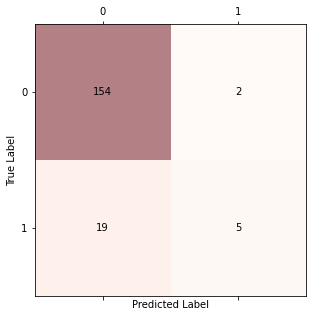

In [134]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_ann3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stochastic Gradient Descent Classifiers
### SGD Model 1

In [135]:
#call the default model
sgd_clf = SGDClassifier(random_state = 8)
#check the default parameter settings
print(sgd_clf)

#fit the classifier to the training data
sgd_clf.fit(X_train,y_train)

#make predictions using the test data
target_predicted_sgd = sgd_clf.predict(X_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=8, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [136]:
#create a classification report
print("SGD Accuracy Score", accuracy_score(y_test, target_predicted_sgd))
print("SGD Recall Score", recall_score(y_test, target_predicted_sgd))
print("SGD ROC AUC Score", roc_auc_score(y_test, target_predicted_sgd))
print(classification_report(y_test, target_predicted_sgd))

SGD Accuracy Score 0.9
SGD Recall Score 0.375
SGD ROC AUC Score 0.6778846153846154
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       156
           1       0.75      0.38      0.50        24

    accuracy                           0.90       180
   macro avg       0.83      0.68      0.72       180
weighted avg       0.89      0.90      0.89       180



In [137]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(sgd_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.71428571 0.92857143 0.92857143 0.88095238 0.85714286 0.85714286
 0.85714286 0.85714286 0.82926829 0.92682927]


0.8637049941927991

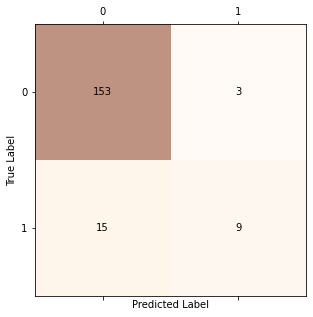

In [138]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_sgd)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SGD Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [139]:
#create the grid
param_grid2 = {'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'class_weight' : ['None', 'balanced'], 'l1_ratio' : [0.0001, 0.001, 0.01, 0.1],
               'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'penalty' : ['l1', 'l2', 'elasticnet']}

#run the grid search
grid_search = GridSearchCV(sgd_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'alpha': 1e-05, 'class_weight': 'balanced', 'l1_ratio': 0.0001, 'loss': 'perceptron', 'penalty': 'l1'}


In [140]:
#call the new model
sgd_clf2 = SGDClassifier(alpha = 0.00001, class_weight = 'balanced', l1_ratio = 0.0001, loss = 'perceptron', penalty = 'l1', random_state = 8)
#check the parameter settings
print(sgd_clf2)

#fit the classifier to the training data
sgd_clf2.fit(X_train,y_train)

#make predictions using the test data
target_predicted_sgd2 = sgd_clf2.predict(X_test)

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.0001, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=8, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [141]:
#create a classification report
print("SGD Accuracy Score", accuracy_score(y_test, target_predicted_sgd2))
print("SGD Recall Score", recall_score(y_test, target_predicted_sgd2))
print("SGD ROC AUC Score", roc_auc_score(y_test, target_predicted_sgd2))
print(classification_report(y_test, target_predicted_sgd2))

SGD Accuracy Score 0.8944444444444445
SGD Recall Score 0.5416666666666666
SGD ROC AUC Score 0.7451923076923075
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       156
           1       0.62      0.54      0.58        24

    accuracy                           0.89       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.89      0.89      0.89       180



In [142]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(sgd_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.61904762 0.85714286 0.97619048 0.76190476 0.80952381 0.85714286
 0.95238095 0.76190476 0.65853659 0.7804878 ]


0.8034262485481998

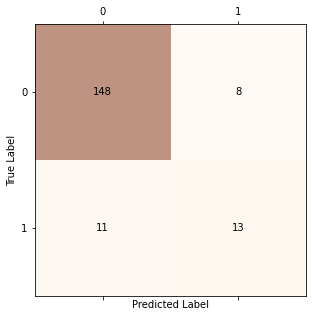

In [143]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_sgd2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SGD Model 3
To further improve the model, more refined values for alpha and the l1_ratio were employed using roc_auc scoring.

In [144]:
#create the grid
param_grid3 = {'alpha' : [0.000001, 0.00001, 0.0001, 0.001, 0.01], 'class_weight' : ['None', 'balanced'], 'l1_ratio' : [0.000001, 0.00001, 0.0001, 0.001, 0.01],
               'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'penalty' : ['l1', 'l2', 'elasticnet']}

#run the grid search
grid_search = GridSearchCV(sgd_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'alpha': 0.001, 'class_weight': 'balanced', 'l1_ratio': 1e-06, 'loss': 'squared_hinge', 'penalty': 'elasticnet'}


In [145]:
#call the new model
sgd_clf3 = SGDClassifier(alpha = 0.001, class_weight = 'balanced', l1_ratio = 0.000001, loss = 'squared_hinge', penalty = 'elasticnet', random_state = 8)
#check the parameter settings
print(sgd_clf3)

#fit the classifier to the training data
sgd_clf3.fit(X_train,y_train)

#make predictions using the test data
target_predicted_sgd3 = sgd_clf3.predict(X_test)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=1e-06, learning_rate='optimal', loss='squared_hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=8, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


In [146]:
#create a classification report
print("SGD Accuracy Score", accuracy_score(y_test, target_predicted_sgd3))
print("SGD Recall Score", recall_score(y_test, target_predicted_sgd3))
print("SGD ROC AUC Score", roc_auc_score(y_test, target_predicted_sgd3))
print(classification_report(y_test, target_predicted_sgd3))

SGD Accuracy Score 0.8888888888888888
SGD Recall Score 0.5416666666666666
SGD ROC AUC Score 0.7419871794871794
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       156
           1       0.59      0.54      0.57        24

    accuracy                           0.89       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.89      0.89      0.89       180



In [147]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(sgd_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.83333333 0.88095238 0.85714286 0.85714286 0.80952381
 0.88095238 0.80952381 0.80487805 0.87804878]


0.8373403019744483

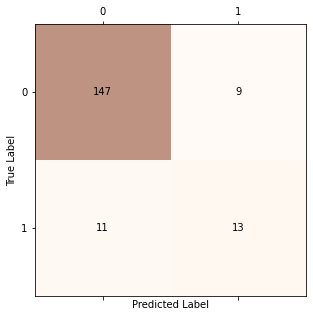

In [148]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_sgd3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Gradient Boosting Classifiers
### GBC Model 1

In [149]:
#call the default model
gbc_clf = GradientBoostingClassifier(random_state = 8)
#check the default parameter settings
print(gbc_clf)

#fit the classifier to the training data
gbc_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_gbc = gbc_clf.predict(X_test)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [150]:
#create a classification report
print("GBC Accuracy Score", accuracy_score(y_test, target_predicted_gbc))
print("GBC Recall Score", recall_score(y_test, target_predicted_gbc))
print("GBC ROC AUC Score", roc_auc_score(y_test, target_predicted_gbc))
print(classification_report(y_test, target_predicted_gbc))

GBC Accuracy Score 0.9166666666666666
GBC Recall Score 0.5416666666666666
GBC ROC AUC Score 0.7580128205128204
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       156
           1       0.76      0.54      0.63        24

    accuracy                           0.92       180
   macro avg       0.85      0.76      0.79       180
weighted avg       0.91      0.92      0.91       180



In [151]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(gbc_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.9047619  0.9047619  0.9047619  0.85714286 0.92857143
 0.9047619  0.80952381 0.82926829 0.85365854]


0.8754355400696865

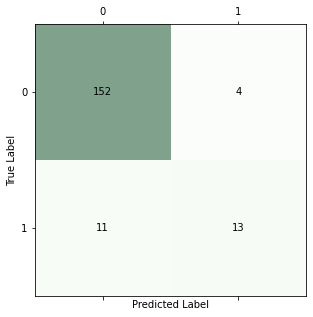

In [152]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_gbc)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### GBC Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [153]:
#create the grid
param_grid2 = {'criterion' : ['friedman_mse', 'mse', 'mae'], 'loss' : ['deviance', 'exponential'], 'max_depth' : [1, 2, 3, 4, 5]}

#run the grid search
grid_search = GridSearchCV(gbc_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 2}


In [154]:
#call the new model
gbc_clf2 = GradientBoostingClassifier(criterion = 'friedman_mse', loss = 'exponential', max_depth = 2, random_state = 8)
#check the parameter settings
print(gbc_clf2)

#fit the classifier to the training data
gbc_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_gbc2 = gbc_clf2.predict(X_test)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [155]:
#create a classification report
print("GBC Accuracy Score", accuracy_score(y_test, target_predicted_gbc2))
print("GBC Recall Score", recall_score(y_test, target_predicted_gbc2))
print("GBC ROC AUC Score", roc_auc_score(y_test, target_predicted_gbc2))
print(classification_report(y_test, target_predicted_gbc2))

GBC Accuracy Score 0.9222222222222223
GBC Recall Score 0.5416666666666666
GBC ROC AUC Score 0.7612179487179487
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       156
           1       0.81      0.54      0.65        24

    accuracy                           0.92       180
   macro avg       0.87      0.76      0.80       180
weighted avg       0.92      0.92      0.92       180



In [156]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(gbc_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.88095238 0.85714286 0.88095238 0.88095238 0.9047619
 0.92857143 0.80952381 0.82926829 0.87804878]


0.8731126596980255

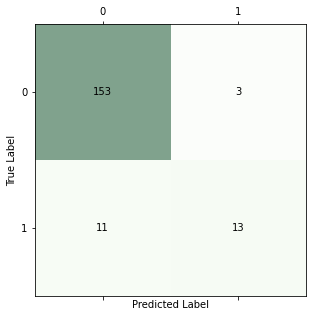

In [157]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_gbc2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### GBC Model 3
To further improve the model, multiple values for the "n_estimators" parameter were checked using roc_auc scoring.

In [158]:
#create the grid
param_grid3 = {'n_estimators' : [50, 60, 70, 80, 90, 100, 110]}

#run the grid search
grid_search = GridSearchCV(gbc_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'n_estimators': 70}


In [159]:
#call the new model
gbc_clf3 = GradientBoostingClassifier(criterion = 'friedman_mse', loss = 'exponential', max_depth = 2, n_estimators = 70, random_state = 8)
#check the parameter settings
print(gbc_clf3)

#fit the classifier to the training data
gbc_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_gbc3 = gbc_clf3.predict(X_test)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [160]:
#create a classification report
print("GBC Accuracy Score", accuracy_score(y_test, target_predicted_gbc3))
print("GBC Recall Score", recall_score(y_test, target_predicted_gbc3))
print("GBC ROC AUC Score", roc_auc_score(y_test, target_predicted_gbc3))
print(classification_report(y_test, target_predicted_gbc3))

GBC Accuracy Score 0.9166666666666666
GBC Recall Score 0.5
GBC ROC AUC Score 0.7403846153846153
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       156
           1       0.80      0.50      0.62        24

    accuracy                           0.92       180
   macro avg       0.86      0.74      0.78       180
weighted avg       0.91      0.92      0.91       180



In [161]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(gbc_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.85714286 0.88095238 0.88095238 0.9047619  0.88095238
 0.9047619  0.83333333 0.82926829 0.90243902]


0.8731707317073172

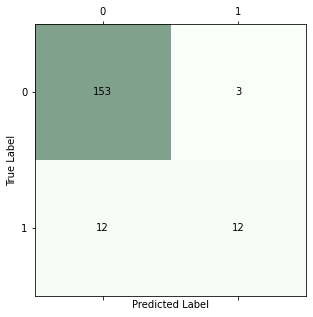

In [162]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_gbc3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Logistic Regression Classifiers
For the second iteration of this project, a logistic regression model was created.
### Logit Model 1

In [163]:
#call the default model
logit_clf = LogisticRegression(max_iter = 10000, random_state = 8)
#check the default parameter settings
print(logit_clf)

#fit the classifier to the training data
logit_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_logit = logit_clf.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [164]:
#create a classification report
print("Logit Accuracy Score", accuracy_score(y_test, target_predicted_logit))
print("Logit Recall Score", recall_score(y_test, target_predicted_logit))
print("Logit ROC AUC Score", roc_auc_score(y_test, target_predicted_logit))
print(classification_report(y_test, target_predicted_logit))

Logit Accuracy Score 0.9111111111111111
Logit Recall Score 0.4583333333333333
Logit ROC AUC Score 0.719551282051282
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       156
           1       0.79      0.46      0.58        24

    accuracy                           0.91       180
   macro avg       0.85      0.72      0.76       180
weighted avg       0.90      0.91      0.90       180



In [165]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(logit_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.9047619  0.92857143 0.88095238 0.83333333 0.88095238
 0.9047619  0.83333333 0.90243902 0.92682927]


0.8853077816492452

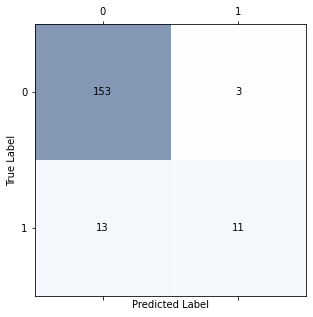

In [166]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_logit)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Logit Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.

In [167]:
#create the grid
param_grid2 = {'C' : [0.5, 1.0, 1.5, 2.0], 'class_weight' : ['balanced'], 'penalty' : ['None', 'l1', 'l2', 'elasticnet'], 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#run the grid search
grid_search = GridSearchCV(logit_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


In [168]:
#call the default model
logit_clf2 = LogisticRegression(C = 1.0, class_weight = 'balanced', penalty = 'l1', solver = 'saga', max_iter = 10000, random_state = 8)
#check the default parameter settings
print(logit_clf2)

#fit the classifier to the training data
logit_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_logit2 = logit_clf2.predict(X_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=8, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)


In [169]:
#create a classification report
print("Logit Accuracy Score", accuracy_score(y_test, target_predicted_logit2))
print("Logit Recall Score", recall_score(y_test, target_predicted_logit2))
print("Logit ROC AUC Score", roc_auc_score(y_test, target_predicted_logit2))
print(classification_report(y_test, target_predicted_logit2))

Logit Accuracy Score 0.8111111111111111
Logit Recall Score 0.9166666666666666
Logit ROC AUC Score 0.8557692307692307
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       156
           1       0.41      0.92      0.56        24

    accuracy                           0.81       180
   macro avg       0.70      0.86      0.72       180
weighted avg       0.91      0.81      0.84       180



In [170]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(logit_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.80952381 0.9047619  0.9047619  0.76190476 0.83333333
 0.83333333 0.78571429 0.80487805 0.90243902]


0.8302555168408826

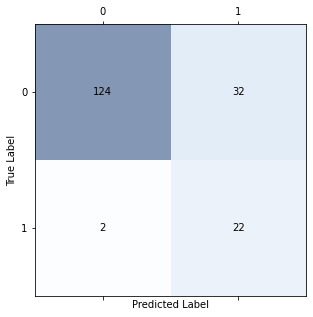

In [171]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_logit2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Logit Model 3
To further improve the model, smaller increments of C were checked.

In [172]:
#create the grid
param_grid3 = {'C' : [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], 'penalty' : ['None', 'l1', 'l2', 'elasticnet'], 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#run the grid search
grid_search = GridSearchCV(logit_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)


Best {'C': 1.1, 'penalty': 'l1', 'solver': 'saga'}


In [173]:
#call the default model
logit_clf3 = LogisticRegression(C = 1.1, class_weight = 'balanced', penalty = 'l1', solver = 'saga', max_iter = 10000, random_state = 8)
#check the default parameter settings
print(logit_clf3)

#fit the classifier to the training data
logit_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_logit3 = logit_clf3.predict(X_test)

LogisticRegression(C=1.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=8, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)


In [174]:
#create a classification report
print("Logit Accuracy Score", accuracy_score(y_test, target_predicted_logit3))
print("Logit Recall Score", recall_score(y_test, target_predicted_logit3))
print("Logit ROC AUC Score", roc_auc_score(y_test, target_predicted_logit3))
print(classification_report(y_test, target_predicted_logit3))

Logit Accuracy Score 0.8111111111111111
Logit Recall Score 0.9166666666666666
Logit ROC AUC Score 0.8557692307692307
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       156
           1       0.41      0.92      0.56        24

    accuracy                           0.81       180
   macro avg       0.70      0.86      0.72       180
weighted avg       0.91      0.81      0.84       180



In [175]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(logit_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.80952381 0.9047619  0.9047619  0.76190476 0.83333333
 0.83333333 0.78571429 0.7804878  0.90243902]


0.8278164924506388

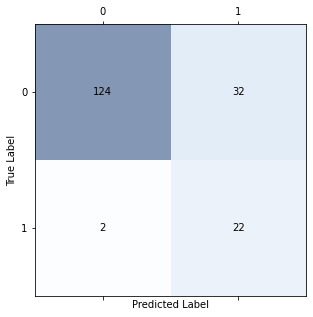

In [176]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_logit3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Bagging Classifiers
### BAG Model 1

In [177]:
#call the default model
bag_clf = BaggingClassifier(random_state = 8)
#check the default parameter settings
print(bag_clf)

#fit the classifier to the training data
bag_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_bag = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=8, verbose=0,
                  warm_start=False)


In [178]:
#create a classification report
print("BAG Accuracy Score", accuracy_score(y_test, target_predicted_bag))
print("BAG Recall Score", recall_score(y_test, target_predicted_bag))
print("BAG ROC AUC Score", roc_auc_score(y_test, target_predicted_bag))
print(classification_report(y_test, target_predicted_bag))

BAG Accuracy Score 0.8944444444444445
BAG Recall Score 0.375
BAG ROC AUC Score 0.6746794871794871
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       156
           1       0.69      0.38      0.49        24

    accuracy                           0.89       180
   macro avg       0.80      0.67      0.71       180
weighted avg       0.88      0.89      0.88       180



In [179]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(bag_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.83333333 0.88095238 0.92857143 0.88095238 0.83333333 0.88095238
 0.88095238 0.83333333 0.85365854 0.90243902]


0.8708478513356562

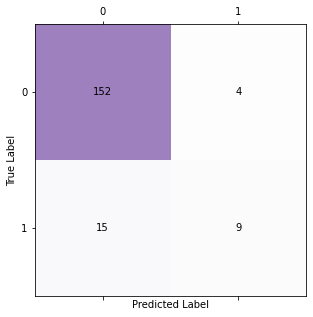

In [180]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_bag)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### BAG Model 2
To try and develop a better model, a grid search was conducted to optimize a few of the hyperparameters using roc_auc scoring.  The three best models thus far were used as choices for the base estimator.

In [181]:
#create the grid
param_grid2 = {'base_estimator' : [et_clf2, svc_lin3, logit_clf3], 'bootstrap' : ['True', 'False'], 'bootstrap_features' : ['True', 'False']}

#run the grid search
grid_search = GridSearchCV(bag_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'base_estimator': ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=8, verbose=0,
                     warm_start=False), 'bootstrap': 'True', 'bootstrap_features': 'True'}


In [182]:
#call the new model
bag_clf2 = BaggingClassifier(base_estimator = et_clf2, bootstrap = True, bootstrap_features = True, random_state = 8)
#check the parameter settings
print(bag_clf2)

#fit the classifier to the training data
bag_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_bag2 = bag_clf2.predict(X_test)

BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=5,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                            

In [183]:
#create a classification report
print("BAG Accuracy Score", accuracy_score(y_test, target_predicted_bag2))
print("BAG Recall Score", recall_score(y_test, target_predicted_bag2))
print("BAG ROC AUC Score", roc_auc_score(y_test, target_predicted_bag2))
print(classification_report(y_test, target_predicted_bag2))

BAG Accuracy Score 0.8944444444444445
BAG Recall Score 0.7083333333333334
BAG ROC AUC Score 0.8157051282051283
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       156
           1       0.59      0.71      0.64        24

    accuracy                           0.89       180
   macro avg       0.77      0.82      0.79       180
weighted avg       0.90      0.89      0.90       180



In [184]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(bag_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.9047619  0.9047619  0.88095238 0.9047619  0.88095238 0.9047619
 0.95238095 0.83333333 0.85365854 0.97560976]


0.8995934959349594

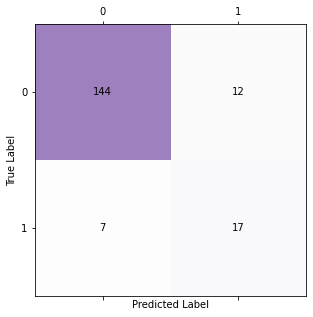

In [185]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_bag2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### BAG Model 3
To further refine the model, the n_estimator parameter was check using roc_auc scoring.

In [186]:
#create the grid
param_grid3 = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

#run the grid search
grid_search = GridSearchCV(bag_clf2, param_grid = param_grid3, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'n_estimators': 70}


In [187]:
#call the new model
bag_clf3 = BaggingClassifier(base_estimator = et_clf2, bootstrap = True, bootstrap_features = True, n_estimators = 70, random_state = 8)
#check the parameter settings
print(bag_clf3)

#fit the classifier to the training data
bag_clf3.fit(X_train, y_train)

#make predictions using the test data
target_predicted_bag3 = bag_clf3.predict(X_test)

BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      class_weight='balanced',
                                                      criterion='gini',
                                                      max_depth=5,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                            

In [188]:
#create a classification report
print("BAG Accuracy Score", accuracy_score(y_test, target_predicted_bag3))
print("BAG Recall Score", recall_score(y_test, target_predicted_bag3))
print("BAG ROC AUC Score", roc_auc_score(y_test, target_predicted_bag3))
print(classification_report(y_test, target_predicted_bag3))

BAG Accuracy Score 0.9
BAG Recall Score 0.75
BAG ROC AUC Score 0.8365384615384616
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       156
           1       0.60      0.75      0.67        24

    accuracy                           0.90       180
   macro avg       0.78      0.84      0.80       180
weighted avg       0.91      0.90      0.90       180



In [189]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(bag_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.9047619  0.9047619  0.92857143 0.88095238 0.88095238
 0.9047619  0.88095238 0.85365854 0.92682927]


0.8947154471544716

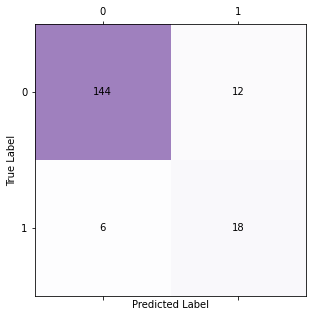

In [190]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_bag3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Purples, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# AdaBoost Classifiers
### AdaBoost Model 1

In [191]:
#call the default model
ada_clf = AdaBoostClassifier(random_state = 8)
#check the default parameter settings
print(ada_clf)

#fit the classifier to the training data
ada_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_ada = ada_clf.predict(X_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8)


In [192]:
#create a classification report
print("ADA Accuracy Score", accuracy_score(y_test, target_predicted_ada))
print("ADA Recall Score", recall_score(y_test, target_predicted_ada))
print("ADA ROC AUC Score", roc_auc_score(y_test, target_predicted_ada))
print(classification_report(y_test, target_predicted_ada))

ADA Accuracy Score 0.8722222222222222
ADA Recall Score 0.4583333333333333
ADA ROC AUC Score 0.6971153846153846
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       156
           1       0.52      0.46      0.49        24

    accuracy                           0.87       180
   macro avg       0.72      0.70      0.71       180
weighted avg       0.87      0.87      0.87       180



In [193]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(ada_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.88095238 0.88095238 0.85714286 0.9047619  0.83333333 0.85714286
 0.83333333 0.78571429 0.90243902 0.90243902]


0.8638211382113822

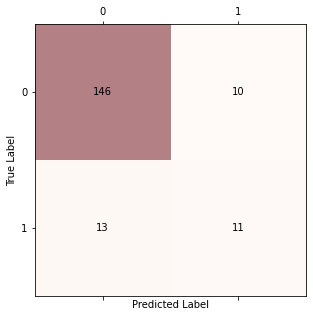

In [194]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_ada)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### AdaBoost Model 2
To try and develop a better model, a grid search was conducted to determine the best base estimator and appropriate algorithm using roc_auc scoring.  The three best models thus far were used as choices for the base estimator.

In [195]:
#create the grid
param_grid2 = {'base_estimator' : [et_clf2, svc_lin3, logit_clf3], 'algorithm' : ['SAMME.R', 'SAMME']}
#run the grid search
grid_search = GridSearchCV(ada_clf, param_grid = param_grid2, scoring = 'roc_auc', n_jobs = -1, cv = 10)
grid_search.fit(X_train, y_train)
print("Best", grid_search.best_params_)

Best {'algorithm': 'SAMME.R', 'base_estimator': ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=8, verbose=0,
                     warm_start=False)}


In [196]:
#call the new model
ada_clf2 = AdaBoostClassifier(base_estimator = et_clf2, algorithm = 'SAMME.R', random_state = 8)
#check the parameter settings
print(ada_clf2)

#fit the classifier to the training data
ada_clf2.fit(X_train, y_train)

#make predictions using the test data
target_predicted_ada2 = ada_clf2.predict(X_test)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=5,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_w

In [197]:
#create a classification report
print("ADA Accuracy Score", accuracy_score(y_test, target_predicted_ada2))
print("ADA Recall Score", recall_score(y_test, target_predicted_ada2))
print("ADA ROC AUC Score", roc_auc_score(y_test, target_predicted_ada2))
print(classification_report(y_test, target_predicted_ada2))

ADA Accuracy Score 0.8944444444444445
ADA Recall Score 0.6666666666666666
ADA ROC AUC Score 0.798076923076923
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       156
           1       0.59      0.67      0.63        24

    accuracy                           0.89       180
   macro avg       0.77      0.80      0.78       180
weighted avg       0.90      0.89      0.90       180



In [198]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(ada_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.9047619  0.9047619  0.9047619  0.92857143 0.80952381 0.9047619
 0.92857143 0.88095238 0.85365854 0.97560976]


0.8995934959349594

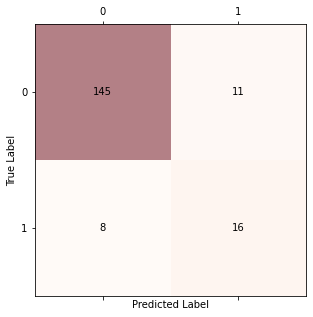

In [199]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_ada2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stacking Classifiers
### STACK Model 1
For the first stacking model, the VotingClassifier was used as the activation function.  The three stacked models used were ET Model 2, SVC (Linear) Model 3, and Logit Model 3.

In [200]:
#call a stack classifier using voting as the final classifier
stack_clf = VotingClassifier(estimators = [('et', et_clf2), ('svc', svc_lin3), ('logit', logit_clf3)], voting = 'hard') 
#check the default parameters
print(stack_clf)

#fit the classifier to the training data
stack_clf.fit(X_train, y_train)

#make predictions using the test data
target_predicted_stack = stack_clf.predict(X_test)

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   class_weight='balanced',
                                                   criterion='gini',
                                                   max_depth=5,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                               

In [201]:
#create a classification report
print("STACK Accuracy Score", accuracy_score(y_test, target_predicted_stack))
print("STACK Recall Score", recall_score(y_test, target_predicted_stack))
print("STACK ROC AUC Score", roc_auc_score(y_test, target_predicted_stack))
print(classification_report(y_test, target_predicted_stack))

STACK Accuracy Score 0.8111111111111111
STACK Recall Score 0.9166666666666666
STACK ROC AUC Score 0.8557692307692307
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       156
           1       0.41      0.92      0.56        24

    accuracy                           0.81       180
   macro avg       0.70      0.86      0.72       180
weighted avg       0.91      0.81      0.84       180



In [202]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(stack_clf, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.76190476 0.83333333 0.92857143 0.88095238 0.76190476 0.83333333
 0.88095238 0.78571429 0.80487805 0.90243902]


0.83739837398374

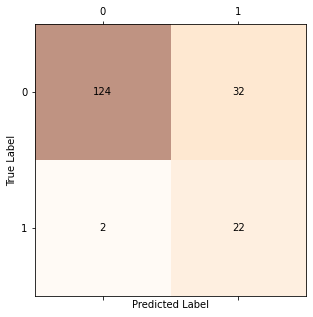

In [203]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_stack)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### STACK Model 2
For the second stacking model, GaussianNB was used as the activation function.  The three stacked models used were ET Model 2, SVC (Linear) Model 3, and Logit Model 3.

In [204]:
#the stacking classifier needs a list where each entry is a list containing the name of the estimator followed by the model object itself
estimator_names = ['et','svc', 'logit']
#build the model using the zip function and then casting to a list
estimator_list=list(zip(estimator_names,[et_clf2, svc_lin3, logit_clf3]))
#use naive bayes as the final level learner
nb = GaussianNB()

#call the new model
stack_clf2 = StackingClassifier(estimators = estimator_list, cv = 10)
#check the parameter settings
print(stack_clf2)

#fit the classifier to the training data
stack_clf2.fit(X_train,y_train)

#make predictions using the test data
target_predicted_stack2 = stack_clf2.predict(X_test)

StackingClassifier(cv=10,
                   estimators=[('et',
                                ExtraTreesClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_wei

In [205]:
#create a classification report
print("STACK Accuracy Score", accuracy_score(y_test, target_predicted_stack2))
print("STACK Recall Score", recall_score(y_test, target_predicted_stack2))
print("STACK ROC AUC Score", roc_auc_score(y_test, target_predicted_stack2))
print(classification_report(y_test, target_predicted_stack2))

STACK Accuracy Score 0.9055555555555556
STACK Recall Score 0.4166666666666667
STACK ROC AUC Score 0.6987179487179487
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       156
           1       0.77      0.42      0.54        24

    accuracy                           0.91       180
   macro avg       0.84      0.70      0.74       180
weighted avg       0.90      0.91      0.89       180



In [206]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(stack_clf2, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.85714286 0.85714286 0.92857143 0.88095238 0.88095238 0.88095238
 0.92857143 0.83333333 0.90243902 0.92682927]


0.8876887340301975

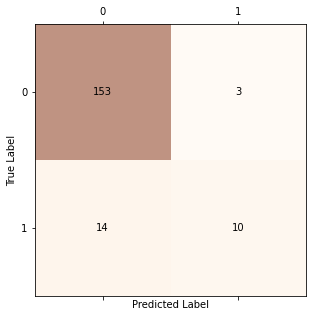

In [207]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_stack2)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### STACK Model 3
For the third stacking model, GaussianNB was used again as the activation function.  In addition to the three models used in the second stacking model, SGD Model 2 was added as an additional layer to try and improve the stacking model.

In [208]:
#the stacking classifier needs a list where each entry is a list containing the name of the estimator followed by the model object itself. 
estimator_names = ['sgd','et','svc', 'logit']
#build the model using the zip function and then casting to a list
estimator_list=list(zip(estimator_names,[sgd_clf2, et_clf2, svc_lin3, logit_clf3]))
# we will use naive bayes as the final level learner
nb = GaussianNB()

#call the new model
stack_clf3 = StackingClassifier(estimators = estimator_list, final_estimator = nb)
#check the parameter settings
print(stack_clf3)

#fit the classifier to the training data
stack_clf3.fit(X_train,y_train)

#make predictions using the test data
target_predicted_stack3 = stack_clf3.predict(X_test)

StackingClassifier(cv=None,
                   estimators=[('sgd',
                                SGDClassifier(alpha=1e-05, average=False,
                                              class_weight='balanced',
                                              early_stopping=False, epsilon=0.1,
                                              eta0=0.0, fit_intercept=True,
                                              l1_ratio=0.0001,
                                              learning_rate='optimal',
                                              loss='perceptron', max_iter=1000,
                                              n_iter_no_change=5, n_jobs=None,
                                              penalty='l1', power_t=0.5,
                                              random_state=8, shuffle=True,
                                              tol=0.001,
                                              validation_fr...
                                LogisticRegression(C=1.1,
           

In [209]:
#create a classification report
print("STACK Accuracy Score", accuracy_score(y_test, target_predicted_stack3))
print("STACK Recall Score", recall_score(y_test, target_predicted_stack3))
print("STACK ROC AUC Score", roc_auc_score(y_test, target_predicted_stack3))
print(classification_report(y_test, target_predicted_stack3))

STACK Accuracy Score 0.9
STACK Recall Score 0.7916666666666666
STACK ROC AUC Score 0.8541666666666665
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       156
           1       0.59      0.79      0.68        24

    accuracy                           0.90       180
   macro avg       0.78      0.85      0.81       180
weighted avg       0.92      0.90      0.91       180



In [210]:
#use 10-fold cross validation to check for overfitting
scores = cross_val_score(stack_clf3, X_train, y_train, cv = 10)
print("Cross Validation Score for each K",scores)
scores.mean()

Cross Validation Score for each K [0.80952381 0.88095238 0.95238095 0.9047619  0.83333333 0.88095238
 0.92857143 0.85714286 0.80487805 0.92682927]


0.8779326364692219

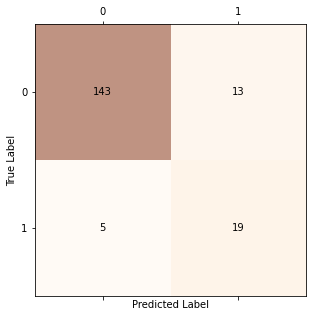

In [211]:
#build a confusion matrix
cm = confusion_matrix(y_test, target_predicted_stack3)
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm, cmap = plt.cm.Oranges, alpha = 0.5)
for i in range(cm.shape[0]) :
    for j in range(cm.shape[1]) :
        ax.text(x = j, y = i, s = cm[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Concluding Remarks
The three best models for consideration are the SVC (Linear) Model 3, Logit Model 3, and STACK Model 1.  All three models produced a ROC AUC score above 0.83 and a recall score of over 0.91.  Which of these models is best for a hospital would depend on the resources of the hospital.  If a hospital has enough tests, then a large false positive predictions could be acceptable.  However, a hospital with limited resources and tests, may require fewer overall false positives even if that means an increase in false negatives.  Moving forward, I believe the SVC (Linear) Model 3 to be most effective for the task at hand.  This model produces the highest recall and highest ROC AUC score.

Limitations of this analysis include: (1) a relatively small sample size from the original dataset, (2) only complete cases were used, which will introduce bia into the model, and (3) this data has been provided by one hospital from one country.